In [56]:
import requests
import os
from PIL import Image
import math
import matplotlib.pyplot as plt
import numpy as np


def download_tile(x, y, z): 
    '''
    Downloads a tile for the given x and y coordinates and zoom level. 
    It is pretty slow as it downloads one tile at a time
    '''
    url = "https://khms.google.com/kh/v=908?x=" + str(x) + "&y=" + str(y) + "&z=" + str(z)
    #print(url)
    imagefile = requests.get(url)
    try:
        os.mkdir("./tiles/")
    except:
        q = 0 # Do nothing if the folder exists
    filename = './tiles/tile_' + str(x) + '_' + str(y) + '_' + str(z) + '.jpg'
    open(filename, 'wb').write(imagefile.content)
    #print("Downloading:", filename)

# # Unused, but might add it later
# def dl_all_tiles_from_zoom(zoom, stitch=False): 
#     xtile = 0
#     ytile = 0
#     max_tile = 2**zoom-1
#     while xtile <= max_tile:
#         while ytile <= max_tile:
#             download_tile(xtile, ytile, zoom)
#             ytile += 1
#         ytile = 0
#         xtile += 1
#     print("Finished downloading files.")


def stitch_tiles(x, y, size, z):
    '''
    Stitches tiles into one large image
    '''
    width = size * 256
    height = size * 256
    max_x = x + size - 1
    max_y = y + size - 1
    x2 = x
    y2 = y
    progress = 0
    total = size*size
    output = Image.new(mode = "RGB", size = (width, height))
    while x2 <= max_x:
        while y2 <= max_y:
            img = Image.open('tiles/tile_' + str(x2) + '_' + str(y2) + '_' + str(z) + '.jpg')
            position_x = (x2 - x) * 256
            position_y = (y2 - y) * 256
            output.paste(img, (position_x, position_y))
            y2 += 1
            progress += 1
            #print("Stitching:", str(progress) + "/" + str(total))
        y2 = y
        x2 += 1
    #print("Writing stitched image to file...")
    output.save('stitched.jpg')
    #print("Done stitching images.")

def dl_square(x, y, z, size): 
    '''
    Downloads a square of tiles, might add other shapes later
    '''
    max_x = x + size - 1
    max_y = y + size - 1
    y2 = y
    #print(f'x: {x}\nmax_x:{max_x}\ny:{y}\nmax_y: {max_y}' )
    while x <= max_x:
        while y <= max_y:
            download_tile(x, y, z)
            y += 1
        y = y2
        x += 1

def latlong_to_xy(lat, lon, zoom):
    '''
    Converts latitude and longitude to tile coordinates
    '''
    lonRad = math.radians(lon)
    latRad = math.radians(lat)
    columnIndex = lonRad
    rowIndex = math.log(math.tan(latRad) + (1.0 / math.cos(latRad)))
    columnNormalized = (1 + (columnIndex / math.pi)) / 2
    rowNormalized = (1 - (rowIndex / math.pi)) / 2
    tilesPerRow = 2 ** zoom
    column = round(columnNormalized * (tilesPerRow - 1))
    row = round(rowNormalized * (tilesPerRow - 1))
    return [column, row]

def delete_tiles():
    '''
    Deletes all thetile  images downloaded after they are stitched
    '''
    folder_path = "./tiles/"
    folder=os.listdir(folder_path)

    for item in folder:
        if item.endswith(".jpg"):
            file_to_del = os.path.join(folder_path, item)
            os.remove(file_to_del)
    
    if os.path.exists(folder_path):
        # checking whether the folder is empty or not
        if len(os.listdir(folder_path)) == 0:
            # removing the file using the os.remove() method
            os.rmdir(folder_path)
        else:
            # messaging saying folder not empty
            print("Folder is not empty")

def calculate_zoom(lat: float):
    '''
    Defines the zoom level closest to 10 meters per pixel
    '''
    #meters_per_pixel = 156543.03392 * Math.cos(latLng.lat() * Math.PI / 180) / Math.pow(2, zoom)
    # meters_per_pixel = 156543.03392 * math.cos(lat * math.pi / 180) / (2 ** zoom)
    meters_per_pixel = 10
    zoom = round(math.log(156543.03392 * math.cos(lat * math.pi / 180) / meters_per_pixel, 2), 0)
    return int(zoom)

def calc_meters_per_pixel(lat, zoom):
    '''
    Calculates how many meters are represented in one pixel
    '''
    return (156543.03392 * math.cos(lat * math.pi / 180) / (2 ** zoom))

def image_resize(meters_per_pixel, img):
    '''
    Resizes image to adjust the ratio to 10 meters per pixel
    '''
    pixels = img.height
    total_meters = meters_per_pixel*pixels
    new_size = int(round(total_meters/10,0))
    new_size = (new_size, new_size)
    return img.resize(new_size)

def image_crop(img):
    '''
    Crops the image to adjust size multiple of 64 pixels
    '''
    crop_pix = int(img.height / 64) * 64
    return img.crop((0,0,crop_pix,crop_pix))

def plot_image_categories(img, categories):
    '''
    Plot the images with the quadrants and correspondent categories
    '''
    xs = range(64, img.height, 64)
    xt = range(20, img.height, 64)
    yt = range(44, img.height, 64)
    plt.imshow(img)
    # multiple lines all full height
    plt.vlines(x=xs, ymin=0, ymax=img.height-1, colors='red', ls='-', lw=0.5)
    plt.hlines(y=xs, xmin=0, xmax=img.height-1, colors='red', ls='-', lw=0.5)
    for item_x,value_x in enumerate(xt):
        for item_y,value_y in enumerate(yt):
            plt.text(value_x, value_y, categories[item_x, item_y], color = 'red')
    plt.show()
    
def plot_image_categories_2(img, categories):
    '''
    Plot the images with the quadrants and correspondent categories
    '''
    new_folder = "./new_tiles/"
    try:
        os.mkdir(new_folder)
    except:
        q = 0 # Do nothing if the folder exists
    
    quads = int(img.height/64)
    fig, axs = plt.subplots(quads, quads, figsize = (10, 10))
    for i in range(quads):
        for j in range(quads):
            img_quad = img.crop((i*64, j*64, i*64+64, j*64+64))
            new_filename = os.path.join(new_folder, f'image_{i}_{j}.jpg')           
            img_quad.save(new_filename)
            axs[j, i].imshow(img_quad)
            axs[j, i].text(22, 40, categories[i, j], color = 'red')
            #axs[i, j].set_title(f'Q: {i}, {j}', fontsize = 5)
            axs[j, i].axis('off')
    plt.show()

In [57]:
# lat = float(input("Enter latitude:"))
# longi = float(input("Enter longitude:"))
# zoom = int(input("Enter zoom level:"))
# size_deg = float(input("Enter size in longitute degrees:"))


#address = '29 avenue de la monta, saint egreve'
address = '101 Thomson Rd, Singapore 307591'
url = 'https://nominatim.openstreetmap.org/search'
#'q' is for query --> look at hte documentation
params = {'q': address, 'format': 'json'}
response = requests.get(url, params = params).json()

lat = float(response[0]['lat'])
longi = float(response[0]['lon'])
# Grenoble
# lat = 45.2245949
# longi = 5.6858155

# # Singapore
# lat = 1.3038116
# longi = 103.84425

zoom = calculate_zoom(lat)
# size_deg = 0.3
# size = int(size_deg * 2 ** zoom / 360)
size = 3
coords = latlong_to_xy(lat, longi, zoom)
dl_square(coords[0], coords[1], zoom, size)
stitch_tiles(coords[0], coords[1], size, zoom)
delete_tiles()
meters_per_pixel = calc_meters_per_pixel(lat, zoom)

768

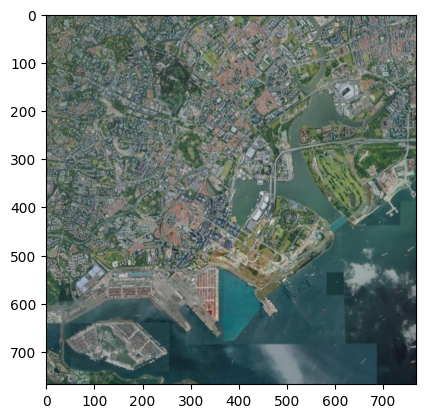

In [58]:
img = Image.open('stitched.jpg')
os.remove('stitched.jpg')
plt.imshow(img);
img.height

734

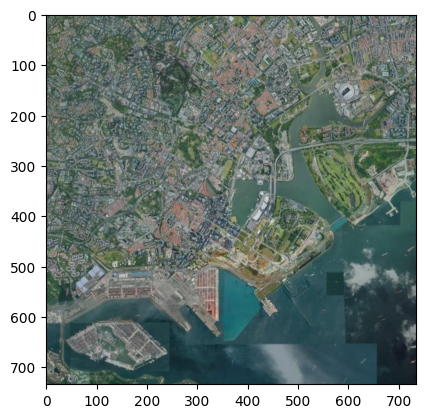

In [59]:
img = image_resize(meters_per_pixel, img)
plt.imshow(img);
img.height

704

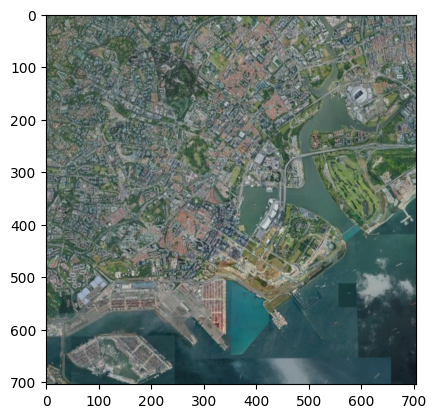

In [60]:
img = image_crop(img)
plt.imshow(img);
img.height

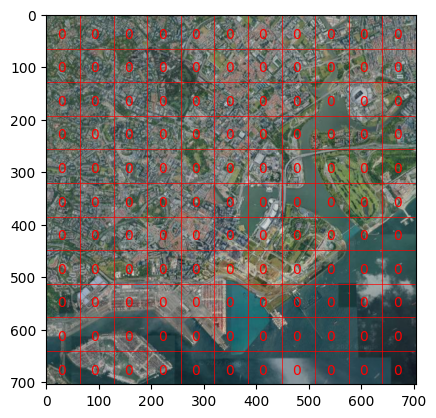

In [61]:
quadrants = int(img.height/64)
categories = np.zeros((quadrants, quadrants), dtype=int)
plot_image_categories(img, categories)

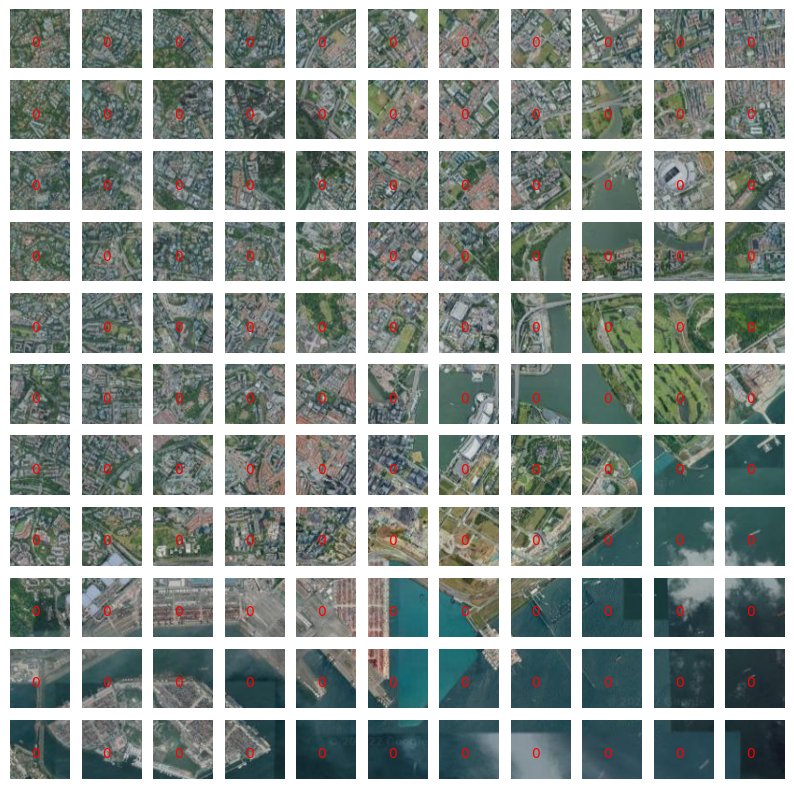

In [62]:
plot_image_categories_2(img, categories)